# Table of Content
* Introduction
* Data Preparation
  * Importing Libraries
  * Loading Data
  * Data Preprocessing
  * Data Augmentation
* Model Building
  * Setting Parameters
  * Building the Model
  * Compiling the Model
* Model Training
  * Training the Model
  * Monitoring Training
* Model Evaluation
  * Evaluating Performance
  * Visualizing Results
* Model Testing
   * Testing with New Data
   * Analyzing Test Results
* Model Saving
   * Saving the Model
   * Loading the Model
* Model Conversion
   * Converting to TFLite
   * Test the TFLite Model using Interpreter
* Conclusion
   * Summary
   * Future Work

# Introduction

Welcome to this script for image classification using the VGG16 model, tailored specifically for recognizing the sign language alphabet of BISINDO (Indonesian Sign Language). This script leverages the powerful VGG16 architecture to create an effective and efficient model for classifying hand signs. The end-to-end process includes building the model, training it with a dataset, testing it with new data, saving the model, converting it to a TFLite format, and finally, packaging everything in a ZIP file for easy distribution.

# Data Preparation
  * Importing Libraries
  * Loading Data
  * Data Preprocessing
  * Data Augmentation

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16

## Loading Data

In [2]:
data_dir = f'/kaggle/input/merged-4-dataset/merged_dataset'

## Data Preprocessing

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1352 files belonging to 26 classes.
Using 1082 files for training.
Found 1352 files belonging to 26 classes.
Using 270 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

(32, 224, 224, 3)
(32, 26)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

0.0 0.897703


## Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
      layers.RandomContrast(0.5),
  ]
)

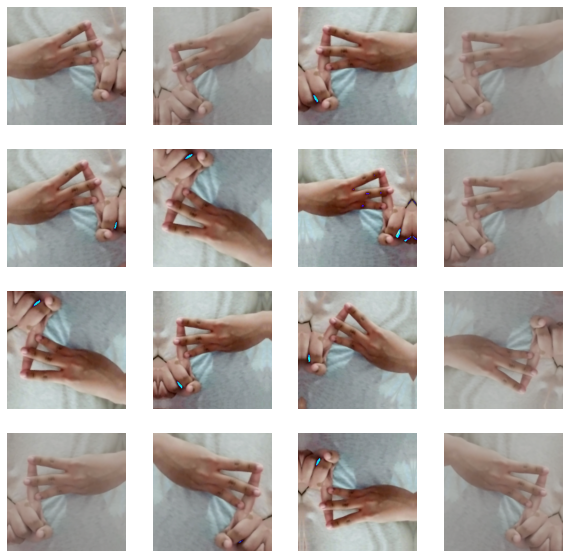

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building
   * Setting Parameters
   * Building the Model
   * Compiling the Model

In [11]:
num_classes = len(class_names)

# Load the VGG16 model, excluding the top (output) layers
local_weights_file = '/kaggle/input/vgg16/tensorflow1/vgg16/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights=local_weights_file)

# Freeze the base model
base_model.trainable = False

# Create the new model on top of the base model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 26)                3354      
Total params: 17,929,434
Trainable params: 3,214,746
Non-trainable params: 14,714,688
__________________________________

# Model Training
  * Training the Model
  * Monitoring Training

## Training the Model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
epochs=100
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Tambahkan EarlyStopping ke dalam callbacks
)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 3.5213 - accuracy: 0.0647

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

34/34 [==============================] - 19s 261ms/step - loss: 3.5213 - accuracy: 0.0647 - val_loss: 3.1337 - val_accuracy: 0.1000
Epoch 2/100
34/34 [==============================] - 3s 84ms/step - loss: 3.1056 - accuracy: 0.0896 - val_loss: 3.0682 - val_accuracy: 0.0852
Epoch 3/100
34/34 [==============================] - 3s 84ms/step - loss: 2.9575 - accuracy: 0.1470 - val_loss: 2.7822 - val_accuracy: 0.1630
Epoch 4/100
34/34 [==============================] - 3s 84ms/step - loss: 2.7766 - accuracy: 0.1885 - val_loss: 2.6559 - val_accuracy: 0.2148
Epoch 5/100
34/34 [==============================] - 3s 85ms/step - loss: 2.5756 - accuracy: 0.2486 - val_loss: 2.3766 - val_accuracy: 0.3148
Epoch 6/100
34/34 [==============================] - 3s 84ms/step - loss: 2.3669 - accuracy: 0.3068 - val_loss: 2.1873 - val_accuracy: 0.3963
Epoch 7/100
34/34 [==============================] - 3s 84ms/step - loss: 2.2052 - accuracy: 0.3706 - val_loss: 1.9881 - val_accuracy: 0.4481
Epoch 8/100
34/3

## Monitoring Training

In [14]:
loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')

9/9 [==============================] - 1s 60ms/step - loss: 0.8280 - accuracy: 0.7667
Validation accuracy: 0.7666666507720947


# Model Evaluation
  * Evaluating Performance
  * Visualizing Results

In [15]:
import os
import shutil

In [16]:
# Path to new data folder
data_folder = '/kaggle/input/databaru'

# List all files in the data folder
image_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]

# Dictionary to store predictions
predictions_dict = {'correct': [], 'incorrect': []}

for image_file in image_files:
    sign_path = os.path.join(data_folder, image_file)
    
    img = tf.keras.utils.load_img(
        sign_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
#     score = tf.nn.softmax(predictions[0])

    predicted_label = class_names[np.argmax(predictions[0])]
    actual_label = image_file.split('.')[0].lower()  # Mengubah ke huruf kecil
    
    if predicted_label.lower() == actual_label:  # Mengubah ke huruf kecil untuk membandingkan
        predictions_dict['correct'].append((image_file, predicted_label, 100 * np.max(predictions[0])))
    else:
        predictions_dict['incorrect'].append((image_file, predicted_label, actual_label, 100 * np.max(predictions[0])))

# Print summary
print("Correct Predictions:")
for image_file, predicted_label, confidence in predictions_dict['correct']:
    print("  {} - Predicted: {} (Confidence: {:.2f}%)".format(image_file, predicted_label, confidence))

print("\nIncorrect Predictions:")
for image_file, predicted_label, actual_label, confidence in predictions_dict['incorrect']:
    print("  {} - Predicted: {} (Actual: {}) (Confidence: {:.2f}%)".format(image_file, predicted_label, actual_label, confidence))

print("\nSummary:")
print("Total Correct Predictions: ", len(predictions_dict['correct']))
print("Total Incorrect Predictions: ", len(predictions_dict['incorrect']))

Correct Predictions:
  s.jpg - Predicted: S (Confidence: 89.82%)
  l.jpg - Predicted: L (Confidence: 43.98%)
  b.jpg - Predicted: B (Confidence: 98.51%)
  c.jpg - Predicted: C (Confidence: 75.08%)
  a.jpg - Predicted: A (Confidence: 98.87%)
  i.jpg - Predicted: I (Confidence: 52.94%)
  h.jpg - Predicted: H (Confidence: 98.29%)
  p.jpg - Predicted: P (Confidence: 60.93%)
  j.jpg - Predicted: J (Confidence: 53.30%)
  k.jpg - Predicted: K (Confidence: 61.05%)
  o.jpg - Predicted: O (Confidence: 36.61%)
  u.jpg - Predicted: U (Confidence: 85.20%)
  g.jpg - Predicted: G (Confidence: 98.55%)
  v.jpg - Predicted: V (Confidence: 96.64%)
  f.jpg - Predicted: F (Confidence: 78.19%)
  w.jpg - Predicted: W (Confidence: 96.96%)
  x.jpg - Predicted: X (Confidence: 80.24%)
  e.jpg - Predicted: E (Confidence: 90.78%)
  z.jpg - Predicted: Z (Confidence: 86.26%)

Incorrect Predictions:
  n.jpg - Predicted: M (Actual: n) (Confidence: 53.88%)
  m.jpg - Predicted: N (Actual: m) (Confidence: 48.00%)
  q.jpg

# Model Saving
   * Saving the Model
   * Loading the Model

## Saving the Model

In [17]:
# tf.keras.models.save_model(model, 'my_model.h5')  # Menyimpan dalam format HDF5
# tf.keras.models.save_model(model, 'my_model', save_format='tf')  # Menyimpan dalam format SavedModel
# tf.keras.Model.save(filepath, overwrite=True, save_format='keras') #keras

model.save('./model/model.h5') #HDF5
model.save('./model/saved_model') #SavedModel
model.save('./model/model.keras')

## Loading the Model

In [18]:
# Memuat model dari model.h5
model = tf.keras.models.load_model('./model/model.h5')

In [19]:
# Path to new data folder
data_folder = '/kaggle/input/databaru'

# List all files in the data folder
image_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]

# Dictionary to store predictions
predictions_dict = {'correct': [], 'incorrect': []}

for image_file in image_files:
    sign_path = os.path.join(data_folder, image_file)
    
    img = tf.keras.utils.load_img(
        sign_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_label = class_names[np.argmax(predictions[0])]
    actual_label = image_file.split('.')[0].lower()  # Mengubah ke huruf kecil
    
    if predicted_label.lower() == actual_label:  # Mengubah ke huruf kecil untuk membandingkan
        predictions_dict['correct'].append((image_file, predicted_label, 100 * np.max(predictions[0])))
    else:
        predictions_dict['incorrect'].append((image_file, predicted_label, actual_label, 100 * np.max(predictions[0])))

# Print summary
print("Correct Predictions:")
for image_file, predicted_label, confidence in predictions_dict['correct']:
    print("  {} - Predicted: {} (Confidence: {:.2f}%)".format(image_file, predicted_label, confidence))

print("\nIncorrect Predictions:")
for image_file, predicted_label, actual_label, confidence in predictions_dict['incorrect']:
    print("  {} - Predicted: {} (Actual: {}) (Confidence: {:.2f}%)".format(image_file, predicted_label, actual_label, confidence))

print("\nSummary:")
print("Total Correct Predictions: ", len(predictions_dict['correct']))
print("Total Incorrect Predictions: ", len(predictions_dict['incorrect']))

Correct Predictions:
  s.jpg - Predicted: S (Confidence: 89.82%)
  l.jpg - Predicted: L (Confidence: 43.98%)
  b.jpg - Predicted: B (Confidence: 98.51%)
  c.jpg - Predicted: C (Confidence: 75.08%)
  a.jpg - Predicted: A (Confidence: 98.87%)
  i.jpg - Predicted: I (Confidence: 52.94%)
  h.jpg - Predicted: H (Confidence: 98.29%)
  p.jpg - Predicted: P (Confidence: 60.93%)
  j.jpg - Predicted: J (Confidence: 53.30%)
  k.jpg - Predicted: K (Confidence: 61.05%)
  o.jpg - Predicted: O (Confidence: 36.61%)
  u.jpg - Predicted: U (Confidence: 85.20%)
  g.jpg - Predicted: G (Confidence: 98.55%)
  v.jpg - Predicted: V (Confidence: 96.64%)
  f.jpg - Predicted: F (Confidence: 78.19%)
  w.jpg - Predicted: W (Confidence: 96.96%)
  x.jpg - Predicted: X (Confidence: 80.24%)
  e.jpg - Predicted: E (Confidence: 90.78%)
  z.jpg - Predicted: Z (Confidence: 86.26%)

Incorrect Predictions:
  n.jpg - Predicted: M (Actual: n) (Confidence: 53.88%)
  m.jpg - Predicted: N (Actual: m) (Confidence: 48.00%)
  q.jpg

# Model Conversion
   * Converting to TFLite
   * Test the TFLite Model using Interpreter

## Converting to TFLite

In [20]:
# Path to the SavedModel directory
saved_model_dir = f'./model/saved_model'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()

# Save the model
tflite_model_path = f'./model/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")

TFLite model saved at: ./model/model.tflite


## Test the TFLite Model using Interpreter

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data and set the tensor
input_data = img_array
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(100 * output_data)

[[1.4163525e+00 9.8922546e-04 1.6239117e+00 1.6622918e-02 5.4757839e-01
  5.8805019e-01 4.2310247e+00 1.6291127e-02 5.1913366e-02 5.2595959e+00
  2.3098154e-01 1.0503126e+00 7.8659493e-04 4.9187959e-04 1.7473355e-01
  6.5066982e-03 1.4499935e-03 1.7601115e-01 1.0583923e-03 6.3831778e-03
  6.3150629e-02 2.4340297e-03 1.7889837e-03 1.2394293e-01 4.1042124e-03
  8.4403534e+01]]


# Conclusion
* Summary
* Future Work

In [22]:
import shutil
shutil.make_archive("Model", 'zip', "./model")

'/kaggle/working/Model.zip'